In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/home/purzelrakete/src/github.com/feldberlin/wavenet


In [2]:
import os

import numpy as np
import torch
import librosa
from torch.nn import functional as F
import matplotlib.pyplot as plt
import IPython.display as ipd

from wavenet import model, train, sample, audio, datasets, utils, viz

# Train on a single Track

Run this on a GPU. Try to overfit a single track.

In [3]:
dry = False
if dry:
    os.environ['WANDB_MODE'] = 'dryrun'

In [4]:
p = model.HParams(n_layers=10).with_all_chans(256)
tp = train.HParams(max_epochs=50, batch_size=8, num_workers=8, learning_rate=0.0026)
utils.cfgdict(p, tp)

{'mixed_precision': True,
 'resample': True,
 'squash_to_mono': False,
 'compress': True,
 'sample_length': 16000,
 'n_audio_chans': 2,
 'sampling_rate': 16000,
 'embed_inputs': False,
 'n_classes': 256,
 'n_layers': 10,
 'kernel_size': 2,
 'dilation_stacks': 3,
 'n_chans': 256,
 'n_chans_embed': 256,
 'n_chans_skip': 256,
 'n_chans_res': 256,
 'n_chans_end': 256,
 'seed': 5762,
 'sample_from_gpu': True,
 'use_deterministic_algorithms': False,
 'train': {'project_name': 'feldberlin-wavenet',
  'max_epochs': 50,
  'batch_size': 8,
  'learning_rate': 0.0026,
  'onecycle': True,
  'betas': (0.9, 0.95),
  'grad_norm_clip': None,
  'callback_fq': 8,
  'num_workers': 8,
  'finder': False}}

In [5]:
utils.seed(p)
ds, ds_test = datasets.tracks('fixtures/aria.wav', 0.2, p)

In [6]:
utils.seed(p)
m = model.Wavenet(p)
t = train.Trainer(m, ds, ds_test, tp, None)

wandb: Currently logged in as: purzelrakete (use `wandb login --relogin` to force relogin)


wandb: WARNING Symlinked 2 files into the W&B run directory, call wandb.save again to sync new files.


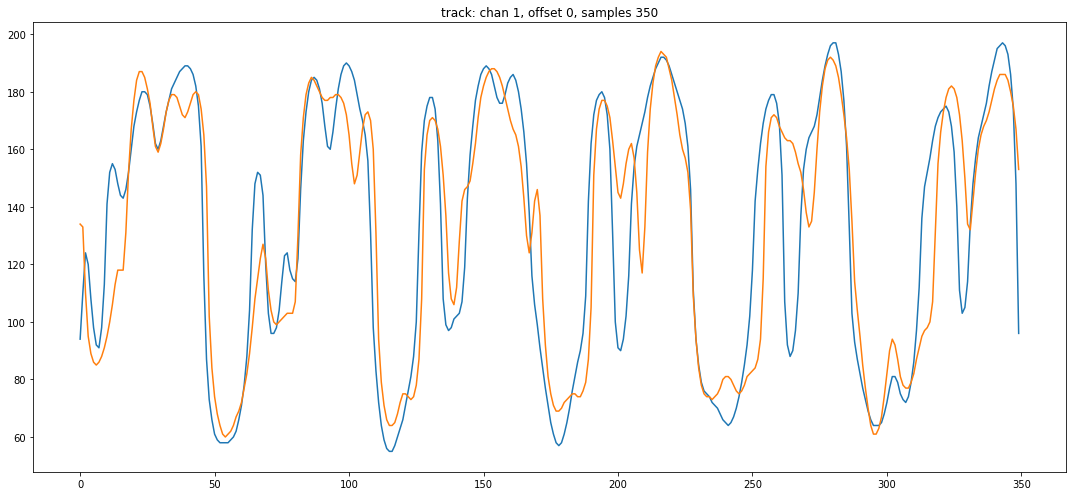

In [7]:
track_i = viz.plot_random_track(ds)
track, *_ = ds[track_i]
ipd.Audio(audio.mu_expand(track.numpy(), p), rate=p.sampling_rate)

In [8]:
utils.seed(p)
t.train()

  0%|          | 0/59 [00:00<?, ?it/s]/home/purzelrakete/src/github.com/feldberlin/wavenet/.venv/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:65: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
50:58 loss 1.18703 lr 1.190443e-08: 100%|██████████| 59/59 [01:26<00:00,  1.47s/it]


In [9]:
utils.seed(p)
tracks, logits, g = sample.fast(m, ds.transforms, utils.decode_random, n_samples=32000, batch_size=10)

In [10]:
for track in tracks:
    track = ds.transforms.normalise(track.numpy())
    track = audio.mu_expand(track, p)
    ipd.display(ipd.Audio(track, rate=p.sampling_rate))